In [1]:
import torch
import numpy as np
from Define_Model.ResNet import ThinResNet
from Define_Model.SoftmaxLoss import ArcSoftmaxLoss, AdditiveMarginLinear
import kaldi_io
from Define_Model.FilterLayer import Back_GradCAM, GAIN
import matplotlib.pyplot as plt
from collections import OrderedDict


In [2]:
model = ThinResNet(resnet_size=34, num_classes=1211, input_norm='Mean', avg_size=4, gain_layer=True, input_dim=161,
                  embedding_size=128, channels=[16, 32, 64, 128], encoder_type='STAP', stride=[2])

# model.classifier = AdditiveMarginLinear(feat_dim=128, n_classes=1211)

In [3]:
ckp_path = '/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/checkpoint/ThinResNet34/vox1/spect_egs_mean/soft/gain_sig_f/0.1_clamp_STAP_None_dp0_avg4_alpha0_em128_wde4/checkpoint_50.pth'
ckp_dict = torch.load(ckp_path)
# print(ckp_dict['state_dict'])
if list(ckp_dict['state_dict'].keys())[0].startswith('module'):
    new_state_dict = OrderedDict()
    for k, v in ckp_dict['state_dict'].items():
        name = k[7:]  # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
        new_state_dict[name] = v  # 新字典的key值对应的value为一一对应的值。

    model.load_state_dict(new_state_dict)
else:             
    model.load_state_dict(ckp_dict['state_dict'])

In [4]:
# vox2 2012
# x = kaldi_io.read_mat('/home/work2020/yangwenhao/project/lstm_speaker_verification/data/vox2/egs/spect/spectrogram/dev_log_v2/feat.0.ark:5')

# vox1 747
x = kaldi_io.read_mat('/home/work2020/yangwenhao/project/lstm_speaker_verification/data/vox1/egs/spect/spectrogram/dev_log/feat.0.ark:4')
x = torch.tensor(x).unsqueeze(0).unsqueeze(0)

idx = 747



In [5]:
# model.gain = GAIN(time=300, freq=161)

back_guide = Back_GradCAM(model, 'layer4')
# xe_criterion = ArcSoftmaxLoss(margin=0.25, s=30, iteraion=0, all_iteraion=0)
print(x.shape)

torch.Size([1, 1, 300, 161])


In [6]:
classfier_label,feat = model(x)

In [7]:
loss = classfier_label[0][idx]
loss.backward(retain_graph=True)


In [8]:
feature, gradient = back_guide()

In [9]:
new_data = model.gain(x.cuda(), feature, gradient)

(-0.5, 299.5, 160.5, -0.5)

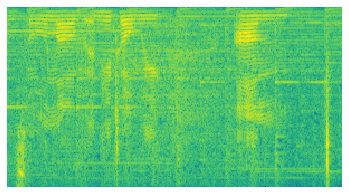

In [15]:
plt.imshow(x.squeeze().transpose(0,1).numpy())
plt.xticks([])
plt.yticks([])
plt.axis('off')

(-0.5, 299.5, 160.5, -0.5)

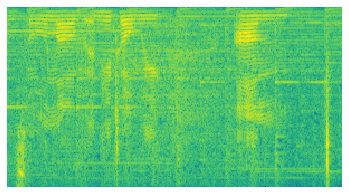

In [16]:
plt.imshow(new_data.squeeze().transpose(0,1).cpu().detach().numpy())
plt.xticks([])
plt.yticks([])
plt.axis('off')


In [17]:
o_x = x.squeeze().transpose(0,1).numpy()
t_x = new_data.squeeze().transpose(0,1).cpu().detach().numpy()
T = (o_x - t_x ) /o_x

(-0.5, 299.5, 160.5, -0.5)

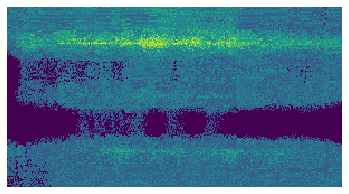

In [29]:
plt.imshow(T/T.max())
plt.xticks([])
plt.yticks([])
plt.axis('off')

In [32]:
print(T.min(), T/T.max())

0.0 [[0.41558507 0.33395568 0.35521725 ... 0.2889469  0.28244    0.3010856 ]
 [0.4005855  0.32910207 0.4502515  ... 0.46380162 0.48521096 0.26083547]
 [0.32146505 0.2725495  0.37623736 ... 0.26287216 0.29189175 0.32618615]
 ...
 [0.32720304 0.34589544 0.25399688 ... 0.30534875 0.49674755 0.26467505]
 [0.         0.         0.         ... 0.2598274  0.2543992  0.28135958]
 [0.         0.         0.         ... 0.30320215 0.32572123 0.30320215]]


In [19]:
print(T.max(), T.min())

2.3659867e-07 0.0


(-0.5, 299.5, 160.5, -0.5)

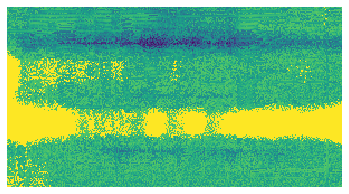

In [31]:
plt.imshow(1-T/T.max())
plt.xticks([])
plt.yticks([])
plt.axis('off')

/home/yangwenhao/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


(-0.5, 299.5, 160.5, -0.5)

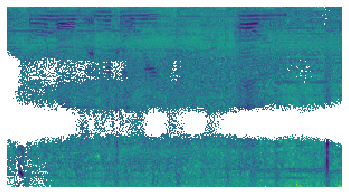

In [27]:


plt.imshow(x.squeeze().transpose(0,1).numpy()*(1-0.1/T))
plt.xticks([])
plt.yticks([])
plt.axis('off')

(-0.5, 299.5, 160.5, -0.5)

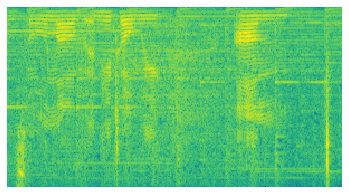

In [26]:
plt.imshow(o_x*(1-T/10*T.max()))
plt.xticks([])
plt.yticks([])
plt.axis('off')